## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to use this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries and dataset.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

df = pd.read_csv('ab_data.csv')

### Accessing the data

In [3]:
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


Number of rows in the dataset

In [5]:
num_rows = df.shape[0]
num_rows

294478

Number of unique users

In [6]:
num_unique_users = df.groupby('user_id').count().shape[0]
num_unique_users

290584

Proportion of users converted

In [8]:
proportion_converted = df.query('converted == 1').count()[0]/num_unique_users
proportion_converted

0.12126269856564711

Number of times the new_page and treatment don't line up

In [9]:
a = df.query('group == "treatment" and landing_page != "new_page"').count()[0]
b = df.query('group == "control" and landing_page == "new_page"').count()[0]
a + b

3893

### Cleaning the data

Eliminating data that cannot be used

In [11]:
# Extracting useful data into two separate dfs and combining said dfs
df_exp = df.query('group == "treatment" and landing_page == "new_page"')
df_cont = df.query('group == "control" and landing_page == "old_page"')
df2 = pd.concat([df_exp, df_cont])

Testing previous code

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### Reassessing the data after cleaning

Number of unique user_ids

In [13]:
df2.groupby('user_id').count().shape[0]

290584

Checking for duplicate entries

In [14]:
test = df2['user_id'].duplicated()
test[test == True]

2893    True
Name: user_id, dtype: bool

Information pertaining to duplicate

In [15]:
df2.iloc[2893]

user_id                             723335
timestamp       2017-01-15 12:29:50.410123
group                            treatment
landing_page                      new_page
converted                                0
Name: 5917, dtype: object

Removing duplicate

In [16]:
df2 = df2.drop(2893)

The probability of an individual converting regardless of the page they receive

In [17]:
df2.query('converted >= 1').count()[0]/df2.count()[0]

0.11959708724499628

The probability of an individual of the control group having converted

In [18]:
p_control = df2.query('converted >= 1 and group == "control"').count()[0]/df2.query('group == "control"').count()[0]
p_control

0.1203863045004612

The probability of an individual of the treatment group having converted

In [19]:
p_treatment = df2.query('converted >= 1 and group == "treatment"').count()[0]/df2.query('group == "control"').count()[0]
p_treatment

0.1188375070556328

The probabiliy that the individual recieved the new page

In [20]:
df2.query('landing_page == "new_page"').count()[0]/df2.count()[0]

0.50006194422266881

##### After initial assessment of the data, there is statistical evidence that the old page has a higher conversion rate but the difference is too small to prove any practical significance for changing to the new page.

<a id='ab_test'></a>
### Part II - A/B Test

### Null and alternative hypothesis


$H_0 = P_{old} >= P_{new}$

$H_1 = P_{old} < P_{new}$

The following is the performing of a sampling distribution for the difference in conversion results between the two pages of 10,000 iterations of calculating an estimate from the null.

The **convert rate** for $p_{new}$ under the null

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

The **convert rate** for $p_{old}$ under the null

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

$n_{new}$ and $n_{old}$

In [23]:
n_new = df2.query('landing_page == "new_page"').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new, n_old

(145310, 145274)

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted** and **old_page_converted**.

In [26]:
new_page_converted = np.random.binomial(n_new, p_new)
old_page_converted = np.random.binomial(n_old, p_old)

$p_{new}$ - $p_{old}$ from 2 previous values

In [27]:
new_page_converted/n_new - old_page_converted/n_old

0.00055547894698632083

Simulating 10,000 $p_{new}$ - $p_{old}$ values using a process similarly to the previous.  Storing all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []

for _ in range(10000):
    new_conv = np.random.binomial(n_new, p_new)
    old_conv = np.random.binomial(n_old, p_old)
    diff = new_conv/n_new - old_conv/n_old
    p_diffs.append(diff)

(array([  1.60000000e+01,   1.61000000e+02,   7.25000000e+02,
          1.99700000e+03,   2.91900000e+03,   2.55300000e+03,
          1.21600000e+03,   3.65000000e+02,   4.60000000e+01,
          2.00000000e+00]),
 array([-0.00444156, -0.00350343, -0.0025653 , -0.00162717, -0.00068904,
         0.00024909,  0.00118722,  0.00212535,  0.00306348,  0.00400161,
         0.00493974]),
 <a list of 10 Patch objects>)

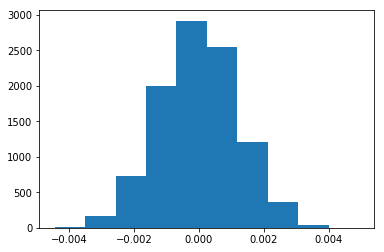

In [29]:
plt.hist(p_diffs)

Proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**?

In [30]:
origional_diff = p_treatment - p_control

p_diffs = np.array(p_diffs)
null_vals = np.random.normal(p_old, p_diffs.std(), 10000)
(p_diffs > origional_diff).mean()

0.89849999999999997

##### The computation executed previously calculates the probability of observing the current statistic derrived from the current sample given that the null hypothesis is true.

##### A P value of .898 indicates that there is no statistical evidence that we should reject the null hypothesis.  There is no evidence that the new page has higher conversion rates.

### Conducting previous analysis with built in methods

In [31]:
import statsmodels.api as sm

convert_old = df.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df.query('landing_page == "old_page"').shape[0]
n_new = df.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Using stats.proportions_ztest to compute test statistic and p-value

In [32]:
from scipy.stats import norm
norm.ppf(1-(0.05/2))

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3683341399998907, 0.9143962454534289)

##### The z-score indicates that, since it does not exceed the critical value (1.959963984540054 at 95% confidence), we fail to reject the null hypothesis that the difference between the two proportions is zero.

##### The p-value computed indicates that there is a 91 percent chance that we will observe the same statistic given that the null is true therefore we should stick to the null being true.

<a id='regression'></a>
### Part III - A regression approach


### Logistic Regression

In [34]:
# Creating column for the intercept and creating dummy varibles

df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

Using **statsmodels** to import regression model.  Instantiating the model and fitting the model using the two columns previously created to predict whether or not an individual converts.

In [35]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of the model

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        23:45:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

##### The P value for ab_page is 0.190. The P value in this calculation indicates the probability that the statistic for the average increase in conversion rate from the new page will be observed given that the null is true. The previous calcuation indicated the probability that the difference between the old page and new page is a non-zero value.  The z-test and the simulation both included one-tailed tests but not the regression.

##### It is a good idea to consider other factors into the regression model so that other correlations may be found between those factors and the desired result. If other correlations are found, said company can implement other strategies for achieving a certain goal.

##### A disadvantage of adding additional terms into the regression model is that there might be multicollinearity and cause the results to be inaccurrate.

### Re-testing with adding an additional variable (country)

In [37]:
# Loading data from another csv file and attaching country column to df2
df3 = pd.read_csv('countries.csv')
new_df = df2.join(df3.set_index('user_id'), on='user_id')
new_df[['CA', 'UK', 'US']] = pd.get_dummies(new_df['country'])

Seeing if the country variable had an effect

In [38]:
lm2 = sm.OLS(new_df['converted'], new_df[['intercept', 'CA', 'UK']])
results2 = lm2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Thu, 16 Aug 2018   Prob (F-statistic):              0.201
Time:                        23:50:45   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1195      0.001    166.244      0.000       0.118       0.121
CA            -0.0042      0.003     -1.516      0.130      -0.010       0.001
UK             0.0010      0.001      0.746      0.455      -0.002       0.004
==============================================================================
Omnibus:                   125552.384   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414306.036
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         4.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Analyzing the interaction between page and country and seeing if there are significant effects on conversion

In [40]:
lm3 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'CA', 'UK']])
results3 = lm3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 16 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        23:54:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

<a id='conclusions'></a>
## Conclusion

##### Through the examination of the variables of page and country both individually and simultaneously, it is concluded that there is no statistical evidence that either page or country has an effect on increasing conversion rate. All P values fail to fall below the .05% error acceptance rate. The P value of a_b page is 0.19, the value relating to how reliable whether an old vs new page condition is in terms of predicting conversion rate. The computation executed for the P value earlier indicated the probability of observing the current statistic derrived from the current sample given that the null hypothesis is true.

##### Based on the statistical findings, said company should not spend company resources on switching web pages.